# 1. Import necessary modules

In [1]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib

# 2. Loading the Data:

In [2]:
# # ZIP files
# train_zip = 'GUIDE_Train.csv.zip'
# test_zip = 'GUIDE_Test.csv.zip'

# # Unziping the training file
# with zipfile.ZipFile(train_zip, 'r') as zip_ref:
#     zip_ref.extractall()

# # Unziping the testing file
# with zipfile.ZipFile(test_zip, 'r') as zip_ref:
#     zip_ref.extractall()

In [3]:
# # Now reading the unzipped CSV files
# train_data = pd.read_csv('GUIDE_Train.csv')
# test_data = pd.read_csv('GUIDE_Test.csv')

# 3. Understanding the Data:
## Dataset Overview:
* GUIDE_Train.csv with 9.5M rows and 45 columns.
* GUIDE_Test.csv with 4.1M rows and 46 columns.

# Train Data

In [4]:
def optimize_memory(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df

In [5]:
chunks = []
train_dataset = "C:\cybersecurity_pday4\mycyber\GUIDE_Train.csv\GUIDE_Train.csv"
# Reading the dataset in chunks and process each chunk
for chunk in pd.read_csv(train_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
train_data = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

In [6]:
train_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [7]:
print(train_data.shape)

(9516837, 45)


In [8]:
train_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City'],
      dtype='object')

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int64   
 1   OrgId               int16   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int16   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       object  
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [10]:
train_data.describe()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,...,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06
mean,8.425494e+11,1.815800e+02,7.066349e+04,4.065188e+05,1.106724e+02,2.947315e+03,9.566476e+04,1.287191e+05,2.857506e+05,1.503317e+05,...,3.342790e+03,8.807955e+02,2.622621e+05,1.076172e+05,3.583477e+03,4.898537e+00,6.465558e+01,2.236742e+02,1.351488e+03,9.936183e+03
std,4.962499e+11,3.867784e+02,1.208369e+05,4.592827e+05,4.351038e+02,1.146150e+04,1.635288e+04,3.399208e+04,1.412240e+05,3.750795e+04,...,5.103381e+02,1.291083e+01,8.152956e+04,3.220835e+04,9.020262e+01,7.035099e-01,9.314929e+00,6.279729e+01,3.509808e+02,2.606812e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.123169e+11,1.000000e+01,5.040000e+02,2.324200e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.500000e+01,1.033600e+04,2.166520e+05,9.000000e+00,1.100000e+01,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.710000e+02,8.432900e+04,6.715770e+05,4.500000e+01,1.800000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.147000e+03,5.997060e+05,1.721456e+06,9.522000e+03,1.131740e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


## Handling Missing Data

In [11]:
train_data.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5468386
IncidentGrade           51340
ActionGrouped         9460773
ActionGranular        9460773
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        9420025
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          9441956
FileName                    0
FolderPath

In [12]:
# Droping Columns with More Than 50% Missing Values:
missing_percentage = train_data.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 50].index
train_data.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Columns dropped due to >50% missing values: {columns_to_drop.tolist()}")

Columns dropped due to >50% missing values: ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


#### 'IncidentGrade', Since this is our target column, we cannot have missing values here.
#### The best option is to drop rows where the IncidentGrade is missing, as imputing the target variable might lead to misleading results.

In [13]:
# Droping rows where 'IncidentGrade' is missing
train_data = train_data.dropna(subset=['IncidentGrade'])

In [14]:
train_data.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [15]:
train_data.duplicated().sum()

np.int64(542692)

In [16]:
# Droping duplicate rows from the dataset
train_data = train_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {train_data.shape[0]}")

Number of rows after removing duplicates: 8922805


In [17]:
# Target variable distribution
print("Target variable distribution:")
train_data['IncidentGrade'].value_counts()

Target variable distribution:


IncidentGrade
BenignPositive    3827800
TruePositive      3140126
FalsePositive     1954879
Name: count, dtype: int64

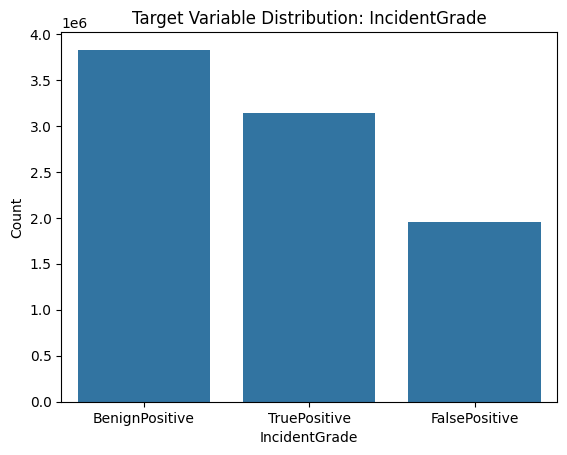

In [18]:
sns.countplot(data=train_data, x='IncidentGrade', order=train_data['IncidentGrade'].value_counts().index)
plt.title('Target Variable Distribution: IncidentGrade')
plt.xlabel('IncidentGrade')
plt.ylabel('Count')
plt.show()

## Feature Exploration and Engineering

In [19]:
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])
train_data['Year'] = train_data['Timestamp'].dt.year
train_data['Month'] = train_data['Timestamp'].dt.month
train_data['Day'] = train_data['Timestamp'].dt.day
train_data['Hour'] = train_data['Timestamp'].dt.hour

train_data.drop(columns='Timestamp',inplace=True)

In [20]:
train_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

# 4. Exploratory Data Analysis (EDA) - Visualizing Distributions

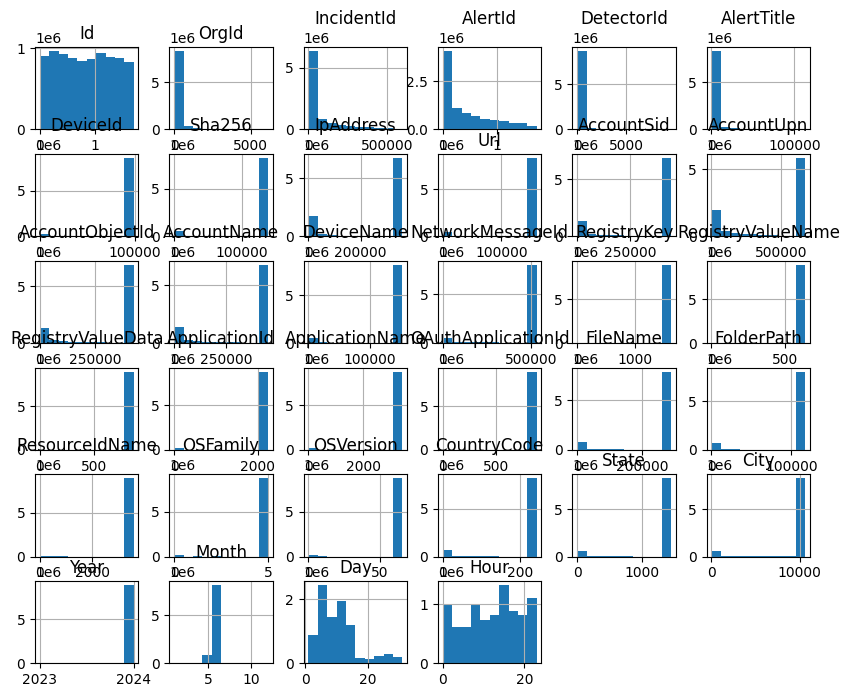

In [21]:
train_data.hist(figsize=(10,8))
plt.show()

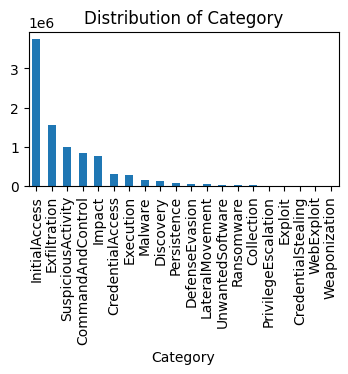

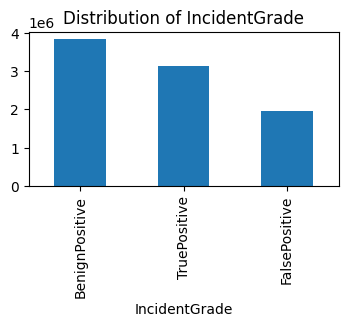

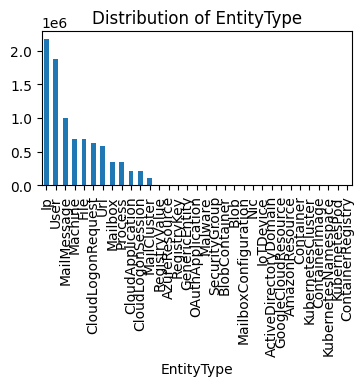

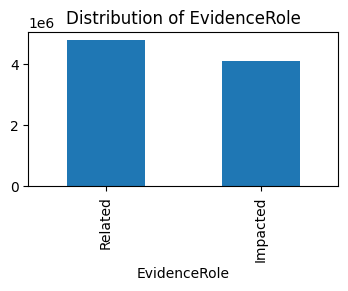

In [22]:
# Bar plot for categorical data
# List of categorical columns in DataFrame
categorical_columns = train_data.select_dtypes(include=['object','category'])

for col in categorical_columns:
    plt.figure(figsize=(4, 2))
    train_data[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.show()

## Visualizing the Data to Identify Outliers

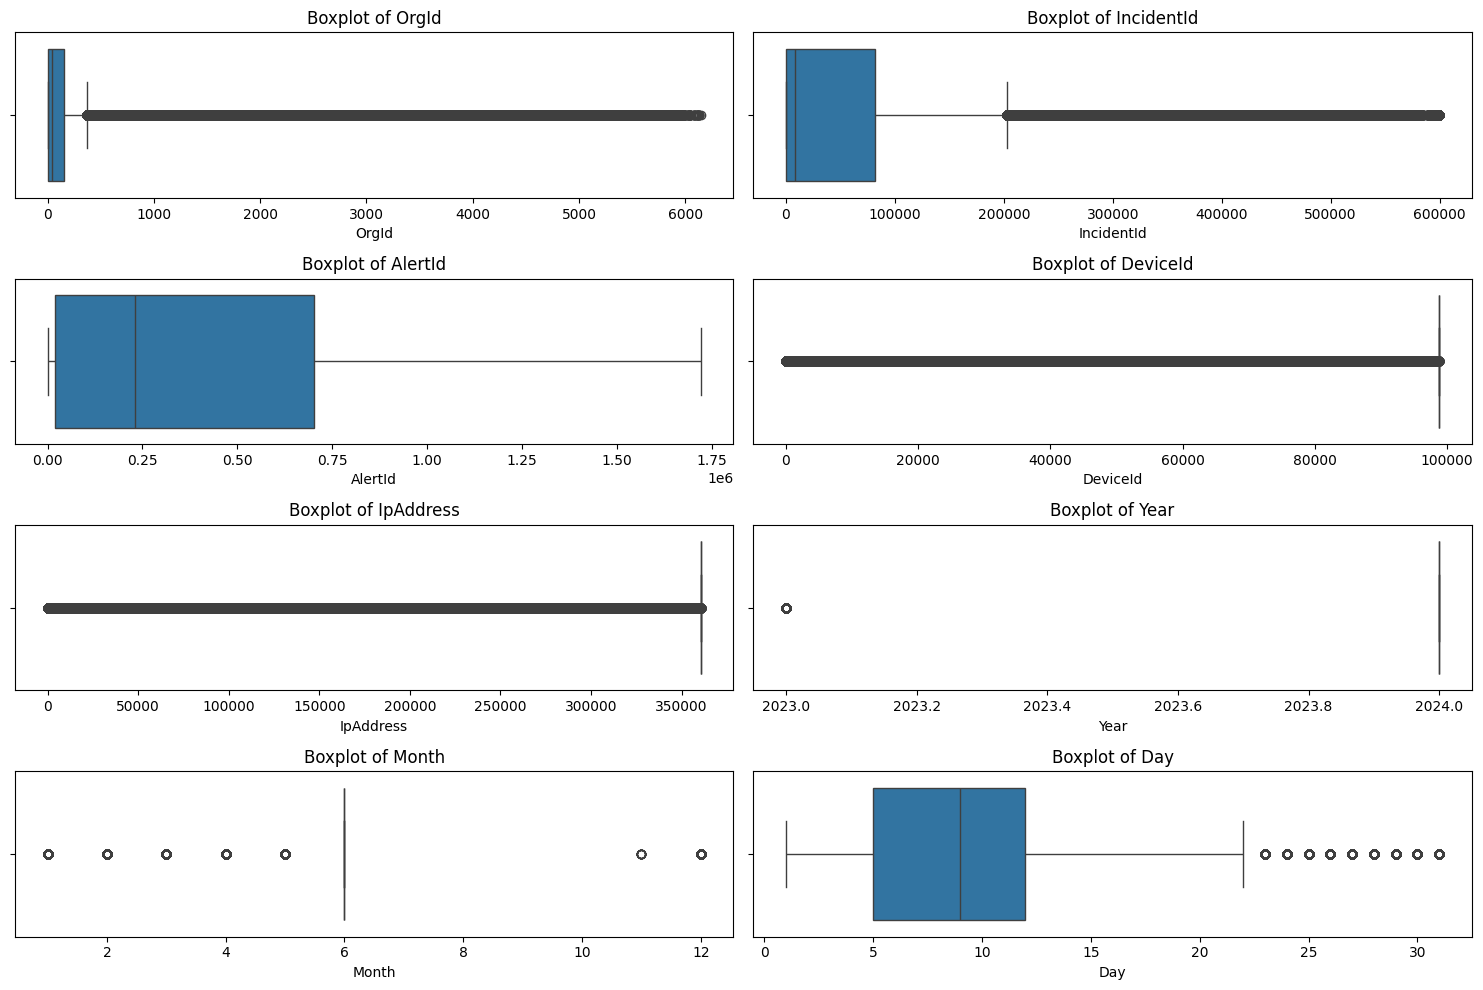

In [23]:
# Ploting box plots for numerical columns
numeric_cols = ['OrgId', 'IncidentId', 'AlertId', 'DeviceId', 'IpAddress', 'Year', 'Month', 'Day']
plt.figure(figsize=(15, 10))
num_plots = len(numeric_cols)
rows = (num_plots + 1) // 2

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=train_data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

## Correlation Analysis

In [24]:
train_data = train_data.copy()

In [25]:
# List of Numerical columns in DataFrame
numeric_columns = train_data.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])
# cheking num columns
numeric_columns.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

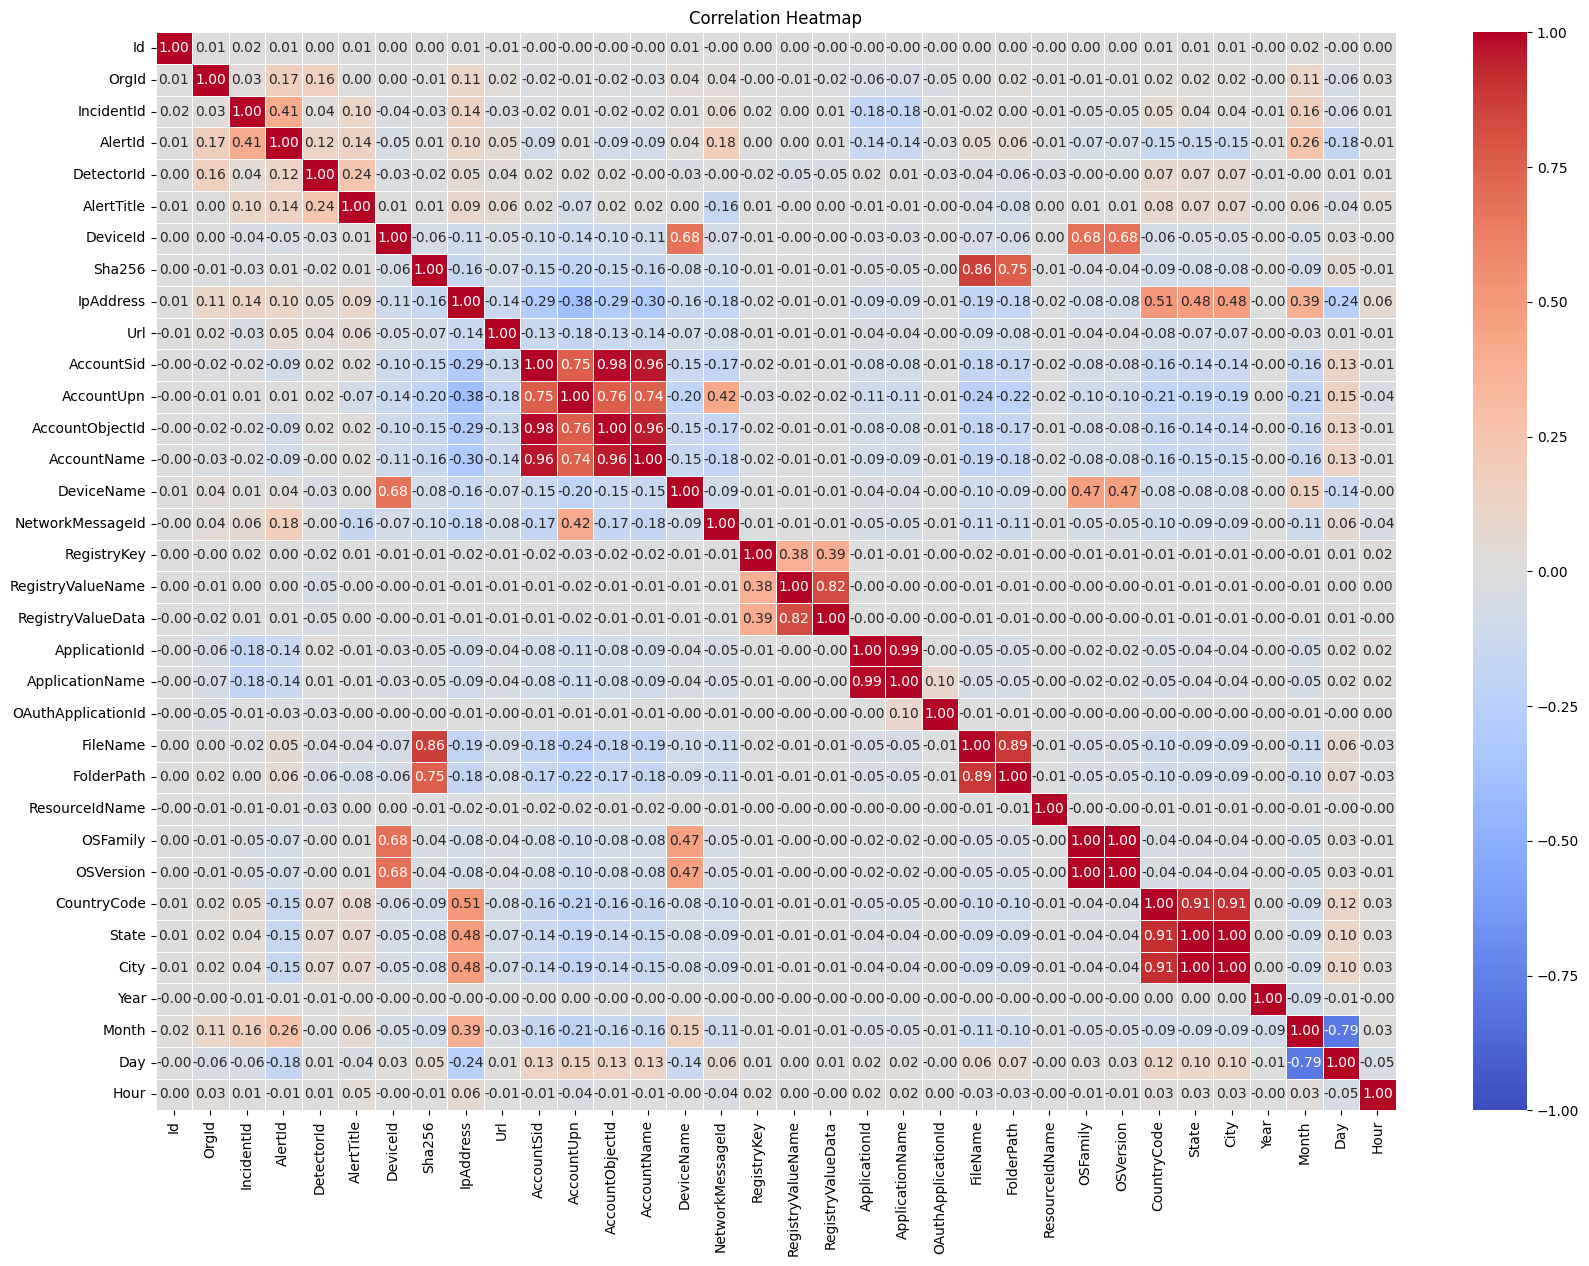

In [26]:
# heatmap visualization
plt.figure(figsize=(20, 14))
sns.heatmap(numeric_columns.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Feature Importance via Random Forest

In [27]:
# ID columns that don't help in model training
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
              'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName']

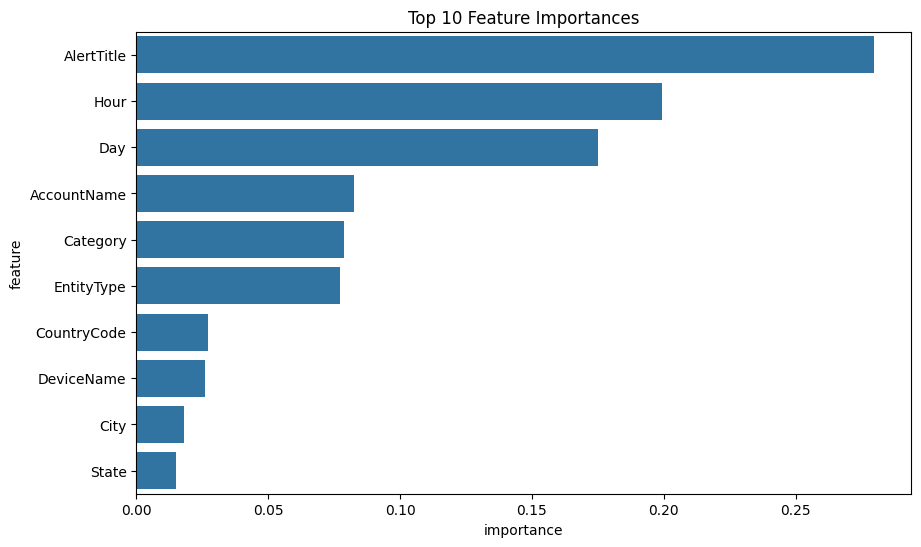

In [28]:
train_sample = train_data.sample(frac=0.001, random_state=42)
X = train_sample.drop(id_columns + ['IncidentGrade'], axis=1, errors='ignore')
y = train_sample['IncidentGrade']

non_numeric_cols = X.select_dtypes(exclude=['number']).columns
le = LabelEncoder()
for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Random Forest model
rf = RandomForestClassifier()
rf.fit(X, y)
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [29]:
#total df imp
imp_features= [
    'Alert Title', 'Hour', 'Day', 'AccountName', 'Category', 'EntityType', 'DeviceName', 'CountryCode', 'State', 'City']

In [30]:
print(train_data.columns)
train_data.shape

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


(8922805, 38)

In [31]:
train_data.nunique()

Id                     707108
OrgId                    5340
IncidentId             448901
AlertId               1248789
DetectorId               7813
AlertTitle              79952
Category                   20
IncidentGrade               3
EntityType                 33
EvidenceRole                2
DeviceId                75557
Sha256                 106416
IpAddress              285957
Url                    123252
AccountSid             353113
AccountUpn             524760
AccountObjectId        338252
AccountName            363254
DeviceName             114267
NetworkMessageId       375196
RegistryKey              1341
RegistryValueName         525
RegistryValueData         699
ApplicationId            1728
ApplicationName          2681
OAuthApplicationId        703
FileName               222085
FolderPath              87832
ResourceIdName           2283
OSFamily                    6
OSVersion                  58
CountryCode               236
State                    1368
City      

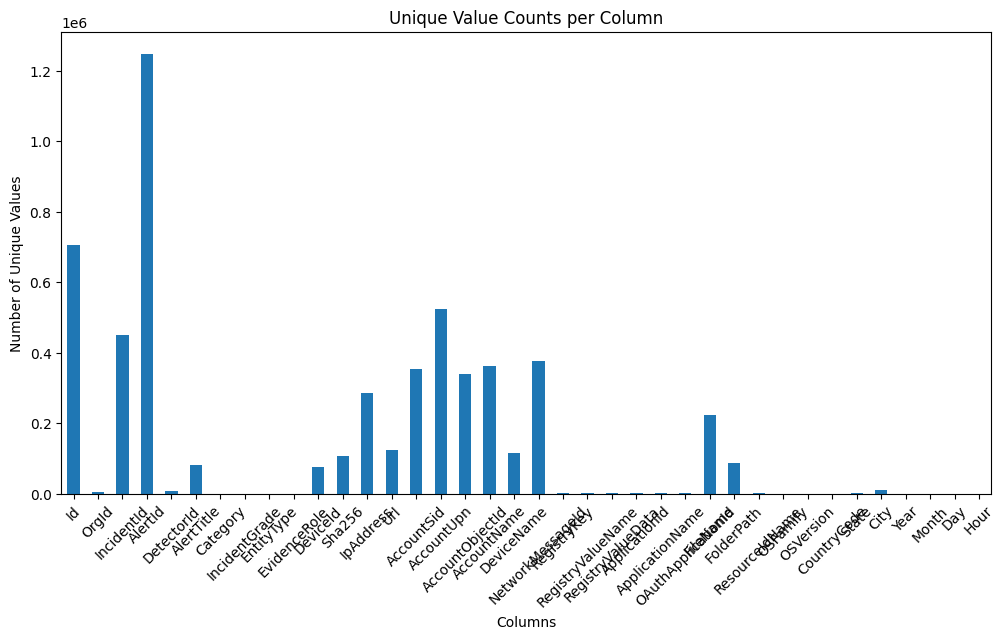

In [32]:
unique_counts = train_data.nunique()
unique_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Unique Value Counts per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45)
plt.show()

Columns like Id, IncidentId, and AlertId contain many unique values.
These are typically identifiers and are unlikely to provide useful information for the classification model, so they should be dropped.
Sha256, IpAddress, AccountName, and Url also have a high number of unique values and may be dropped for similar reasons.

In [33]:
train_data['AlertTitle'].value_counts()

AlertTitle
0         1320112
2          596458
1          480010
3          411725
4          411413
           ...   
111353          1
111201          1
88007           1
112485          1
110231          1
Name: count, Length: 79952, dtype: int64

In [34]:
train_data['Url'].value_counts()

Url
160396    8333372
0            8195
1            6607
2            5264
6            4238
           ...   
90529           1
120679          1
93239           1
107481          1
137238          1
Name: count, Length: 123252, dtype: int64

In [35]:
train_data['DeviceName'].value_counts().head(20)

DeviceName
153085    8228357
0            4376
1            3944
5            2153
4            2152
6            1879
13           1727
7            1631
10           1545
9            1519
8            1512
11           1284
12           1251
16           1187
15           1095
14           1094
22           1021
28            932
20            920
17            813
Name: count, dtype: int64

In [36]:
train_data['City'].value_counts()

City
10630    8295070
0         103145
1          22075
2          19195
3          15787
          ...   
5256           1
9303           1
9449           1
7797           1
9954           1
Name: count, Length: 9342, dtype: int64

In [37]:
train_data['OrgId'].value_counts()

OrgId
0       844832
2       236415
1       210077
3       189731
5       173279
         ...  
6100         1
4594         1
6090         1
6129         1
5009         1
Name: count, Length: 5340, dtype: int64

In [38]:
train_data['AccountSid'].value_counts().head(20)

AccountSid
441377    6855512
0           14469
1            8978
2            6017
3            5262
4            3770
5            3596
7            3144
8            2832
11           2552
6            2353
9            2340
12           2129
15           1993
14           1986
17           1930
18           1924
16           1878
19           1859
21           1847
Name: count, dtype: int64

In [39]:
train_data['AccountSid'].value_counts()

AccountSid
441377    6855512
0           14469
1            8978
2            6017
3            5262
           ...   
395885          1
411098          1
302845          1
360065          1
344710          1
Name: count, Length: 353113, dtype: int64

In [40]:
train_data['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    3827800
TruePositive      3140126
FalsePositive     1954879
Name: count, dtype: int64

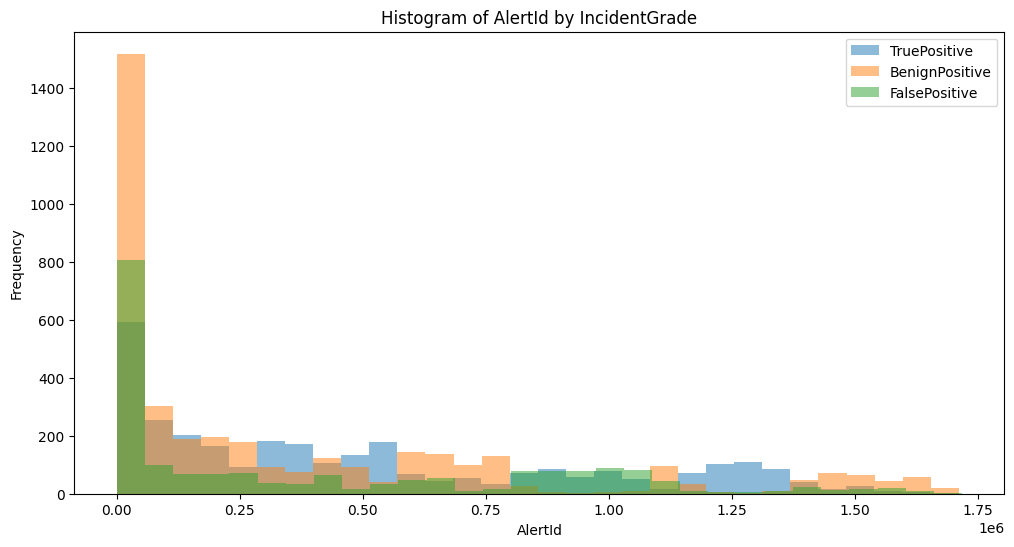

In [42]:
train_sample = train_data.sample(frac=0.001, random_state=42)

plt.figure(figsize=(12, 6))
for grade in train_sample['IncidentGrade'].unique():
    subset = train_sample[train_sample['IncidentGrade'] == grade]
    plt.hist(subset['AlertId'], bins=30, alpha=0.5, label=grade)

plt.xlabel('AlertId')
plt.ylabel('Frequency')
plt.title('Histogram of AlertId by IncidentGrade')
plt.legend()
plt.show()

In [43]:
# These features have minimal importance or are unlikely to impact your classification outcome
columns_to_drop = [
    'Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DetectorId','Sha256', 'IpAddress', 
    'AccountSid', 'AccountUpn', 'AccountObjectId', 'DeviceId', 'NetworkMessageId',
    'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
    'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSVersion'
]
train_data.drop(columns=columns_to_drop, inplace=True)

In [44]:
print(train_data.columns)
train_data.shape

Index(['AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State',
       'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


(8922805, 16)

## Handling Outliers

In [45]:
def handle_outliers(df, iqr_multiplier=3.0):
    numeric_features = df.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])
    for col in numeric_features.columns:
        # IQR method
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
        # Quantile Capping
        q_low = df[col].quantile(0.01)
        q_high = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=q_low, upper=q_high)
        
    return df

In [46]:
train_data.head()

,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,Url,AccountName,DeviceName,OSFamily,CountryCode,State,City,Year,Month,Day,Hour
0,6,InitialAccess,TruePositive,Ip,Related,160396,453297,153085,5,31,6,3,2024,6,4,6
1,43,Exfiltration,FalsePositive,User,Impacted,160396,24887,153085,5,242,1445,10630,2024,6,14,3
2,298,InitialAccess,FalsePositive,Url,Related,68652,453297,153085,5,242,1445,10630,2024,6,13,4
3,2,CommandAndControl,BenignPositive,Url,Related,13,453297,153085,5,242,1445,10630,2024,6,10,16
4,74,Execution,TruePositive,User,Impacted,160396,479,153085,5,242,1445,10630,2024,6,15,1


In [47]:
# # Usage
# train_data = handle_outliers(train_data, iqr_multiplier=3.0)

In [48]:
train_data.shape

(8922805, 16)

## Scaling/Normalization
## StandardScaler
* Using StandardScaler because:
1. StandardScaler standardizes features to have zero mean and unit variance,
   which is beneficial for algorithms that assume normality or are sensitive to feature scaling.
2. It is less sensitive to outliers compared to MinMaxScaler, which compresses data based on min and max values.
3. Handles Non-Uniform Distributions

In [49]:
# # Numerical columns
# # Excludeing ID columns from scaling
# numeric_features = train_data.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64']).drop(columns=id_columns, errors='ignore')

# # Scaling 
# scaler = StandardScaler()

# # Applying StandardScaler to Numerical columns
# train_data[numeric_features.columns] = scaler.fit_transform(numeric_features)

## Encoding Categorical Variables
* Label Encoding for Ordinal Variables
* One-hot encoding for nominal columns

In [50]:
categorical_columns = ['AlertTitle', 'Category', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State', 'City', 'Year',
       'Month', 'Day', 'Hour']

In [51]:
# List of columns to process
columns_to_group = ['AlertTitle', 'Url', 'AccountName', 'DeviceName', 'CountryCode', 'State', 'City']

# Looping through each column and grouping the less frequent values into "Others"
for column in columns_to_group:
    category_counts = train_data[column].value_counts()
    top_categories = category_counts.nlargest(5).index
    train_data[column] = train_data[column].where(train_data[column].isin(top_categories), 'Others')

# Now verifing the changes
train_data

,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,Url,AccountName,DeviceName,OSFamily,CountryCode,State,City,Year,Month,Day,Hour
0,Others,InitialAccess,TruePositive,Ip,Related,160396,453297,153085,5,Others,Others,3,2024,6,4,6
1,Others,Exfiltration,FalsePositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,14,3
2,Others,InitialAccess,FalsePositive,Url,Related,Others,453297,153085,5,242,1445,10630,2024,6,13,4
3,2,CommandAndControl,BenignPositive,Url,Related,Others,453297,153085,5,242,1445,10630,2024,6,10,16
4,Others,Execution,TruePositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516832,Others,InitialAccess,TruePositive,CloudLogonRequest,Related,160396,453297,153085,5,242,1445,10630,2024,6,8,15
9516833,2,CommandAndControl,BenignPositive,Url,Related,Others,453297,153085,5,242,1445,10630,2024,6,6,9
9516834,Others,Exfiltration,BenignPositive,MailMessage,Impacted,160396,453297,153085,5,242,1445,10630,2024,6,11,22
9516835,Others,Impact,BenignPositive,Ip,Related,160396,453297,153085,5,242,1445,10630,2024,5,20,23


In [52]:
# # Encoding categorical variables
# categorical_columns = ['Category','IncidentGrade', 'EntityType', 'EvidenceRole', 'OSVersion']

# # Useing LabelEncoder for categorical variables
# label_encoder = LabelEncoder()
# for col in categorical_columns:
#     train_data[col] = label_encoder.fit_transform(train_data[col])

In [53]:
# Label Encoding for IncidentGrade (Target Variable)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_data['IncidentGrade'] = le.fit_transform(train_data['IncidentGrade'])

# One-Hot Encoding for nominal features
train_data = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)

In [54]:
train_data.shape

(8922805, 154)

## Saving the Cleaned Train Data set as Joblib for further processing

In [55]:
train_dataset = train_data.reset_index(drop=True)


In [56]:
# Saveing the data using Joblib
joblib.dump(train_data, 'encoded_train_data.joblib')

['encoded_train_data.joblib']

In [57]:
# Loading the data using Joblib
train_data = joblib.load('encoded_train_data.joblib')

In [58]:
train_data.head()

,IncidentGrade,AlertTitle_1,AlertTitle_2,AlertTitle_3,AlertTitle_4,AlertTitle_Others,Category_CommandAndControl,Category_CredentialAccess,Category_CredentialStealing,Category_DefenseEvasion,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,2,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,False,True,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,2,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [59]:
train_data.shape

(8922805, 154)

In [60]:
print(train_data.memory_usage(deep=True).sum() / (1024 ** 2), "MB")

1438.0970430374146 MB


In [61]:
# train_data.to_csv("final_train_data.csv", index=False)

# train_data=pd.read_csv("final_train_data.csv")

# Test Data

In [62]:
chunks = []
test_dataset = "C:\cybersecurity_pday4\mycyber\GUIDE_Test.csv\GUIDE_Test.csv"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(test_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
test_data = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

In [63]:
test_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public


In [64]:
print(test_data.shape)

(4147992, 46)


In [65]:
# Columns of both datasets
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

# Difference columns
print("Columns in Train but not in Test:", train_columns - test_columns)
print("Columns in Test but not in Train:", test_columns - train_columns)

Columns in Train but not in Test: {'EntityType_AmazonResource', 'EntityType_Nic', 'CountryCode_Others', 'AccountName_3', 'AlertTitle_4', 'EvidenceRole_Related', 'Hour_22', 'Day_14', 'Day_15', 'AccountName_1', 'Hour_4', 'DeviceName_153085', 'Day_24', 'EntityType_ContainerImage', 'DeviceName_5', 'Category_SuspiciousActivity', 'Category_UnwantedSoftware', 'Url_160396', 'Month_5', 'Day_16', 'OSFamily_2', 'EntityType_MailCluster', 'EntityType_Process', 'Url_2', 'Day_30', 'Category_Execution', 'Day_27', 'Category_WebExploit', 'Day_6', 'DeviceName_1', 'AlertTitle_2', 'Hour_14', 'EntityType_File', 'Day_18', 'Hour_1', 'Day_20', 'Category_Impact', 'EntityType_OAuthApplication', 'Day_4', 'Hour_8', 'AlertTitle_Others', 'EntityType_CloudLogonSession', 'State_3', 'Day_11', 'EntityType_Mailbox', 'CountryCode_4', 'Hour_7', 'Hour_19', 'Day_2', 'EntityType_CloudApplication', 'Day_19', 'EntityType_KubernetesPod', 'Day_21', 'Hour_2', 'Category_DefenseEvasion', 'Hour_12', 'Month_4', 'Hour_20', 'EntityType_

In [66]:
# Problematic columns in both datasets
print(train_data[list(train_columns - test_columns)].head())
print(test_data[list(test_columns - train_columns)].head())


   EntityType_AmazonResource  EntityType_Nic  CountryCode_Others  \
0                      False           False                True   
1                      False           False               False   
2                      False           False               False   
3                      False           False               False   
4                      False           False               False   

   AccountName_3  AlertTitle_4  EvidenceRole_Related  Hour_22  Day_14  Day_15  \
0          False         False                  True    False   False   False   
1          False         False                 False    False    True   False   
2          False         False                  True    False   False   False   
3          False         False                  True    False   False   False   
4          False         False                 False    False   False    True   

   AccountName_1  ...  Day_26  Url_1  OSFamily_3  Hour_17  Month_12  Hour_23  \
0          False  ...   

In [67]:
print("Target column in Train:", 'IncidentGrade' in train_data.columns)
print("Target column in Test:", 'IncidentGrade' in test_data.columns)

Target column in Train: True
Target column in Test: True


In [68]:
print(test_data['Usage'].unique())
print(test_data['Usage'].head())

['Private', 'Public']
Categories (2, object): ['Private', 'Public']
0    Private
1     Public
2     Public
3     Public
4     Public
Name: Usage, dtype: category
Categories (2, object): ['Private', 'Public']


In [69]:
len(test_columns)

46

The Usage column, containing 'Private' and 'Public' values, does not provide relevant information for predicting IncidentGrade and is absent in the training dataset. Thus, it is dropped to reduce noise in the model.

In [70]:
test_data.drop(columns='Usage',inplace=True)
# checking the shape of column
test_data.shape[1]

45

In [71]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int64   
 1   OrgId               int16   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int16   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       category
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [72]:
test_data.describe()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,...,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06
mean,8.462250e+11,1.756698e+02,6.780345e+04,4.072191e+05,1.008391e+02,2.529514e+03,9.575061e+04,1.283939e+05,2.873898e+05,1.504279e+05,...,3.342993e+03,8.808119e+02,2.618998e+05,1.074020e+05,3.583541e+03,4.899529e+00,6.466873e+01,2.222218e+02,1.344570e+03,9.883839e+03
std,4.923351e+11,3.708729e+02,1.178736e+05,4.550578e+05,4.082934e+02,1.044138e+04,1.615628e+04,3.457595e+04,1.400920e+05,3.734754e+04,...,5.096996e+02,1.238317e+01,8.208434e+04,3.260346e+04,9.012124e+01,7.001299e-01,9.269678e+00,6.499822e+01,3.626851e+02,2.696302e+03
min,1.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.209068e+11,8.000000e+00,4.110000e+02,2.365900e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.300000e+01,8.818000e+03,2.228970e+05,7.000000e+00,9.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.730000e+02,7.944000e+04,6.711010e+05,3.900000e+01,1.160000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.138000e+03,5.997000e+05,1.721457e+06,9.520000e+03,1.131690e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


## Handling Missing Data

In [73]:
test_data.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       2307104
IncidentGrade               0
ActionGrouped         4146079
ActionGranular        4146079
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        4106285
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          4116614
FileName                    0
FolderPath

In [74]:
# Droping Columns with More Than 50% Missing Values:
missing_percentage = test_data.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 50].index
test_data.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Columns dropped due to >50% missing values: {columns_to_drop.tolist()}")

Columns dropped due to >50% missing values: ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


In [75]:
test_data.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [76]:
test_data.duplicated().sum()

np.int64(225297)

In [77]:
# Droping duplicate rows from the dataset
test_data = test_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {test_data.shape[0]}")

Number of rows after removing duplicates: 3922695


In [78]:
# Target variable distribution
print("Target variable distribution:")
test_data['IncidentGrade'].value_counts()

Target variable distribution:


IncidentGrade
BenignPositive    1630942
TruePositive      1422856
FalsePositive      868897
Name: count, dtype: int64

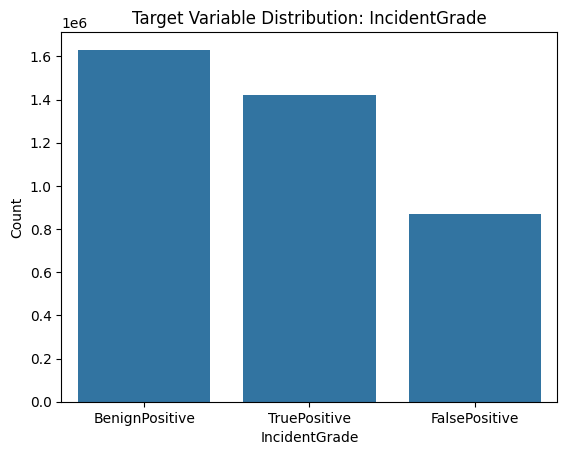

In [79]:
sns.countplot(data=test_data, x='IncidentGrade', order=test_data['IncidentGrade'].value_counts().index)
plt.title('Target Variable Distribution: IncidentGrade')
plt.xlabel('IncidentGrade')
plt.ylabel('Count')
plt.show()

## Feature Exploration and Engineering

In [80]:
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'])
test_data['Year'] = test_data['Timestamp'].dt.year
test_data['Month'] = test_data['Timestamp'].dt.month
test_data['Day'] = test_data['Timestamp'].dt.day
test_data['Hour'] = test_data['Timestamp'].dt.hour

test_data.drop(columns='Timestamp',inplace=True)

In [81]:
test_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

# Exploratory Data Analysis (EDA) - Visualizing Distributions

In [82]:
test_data1 =test_data.copy()

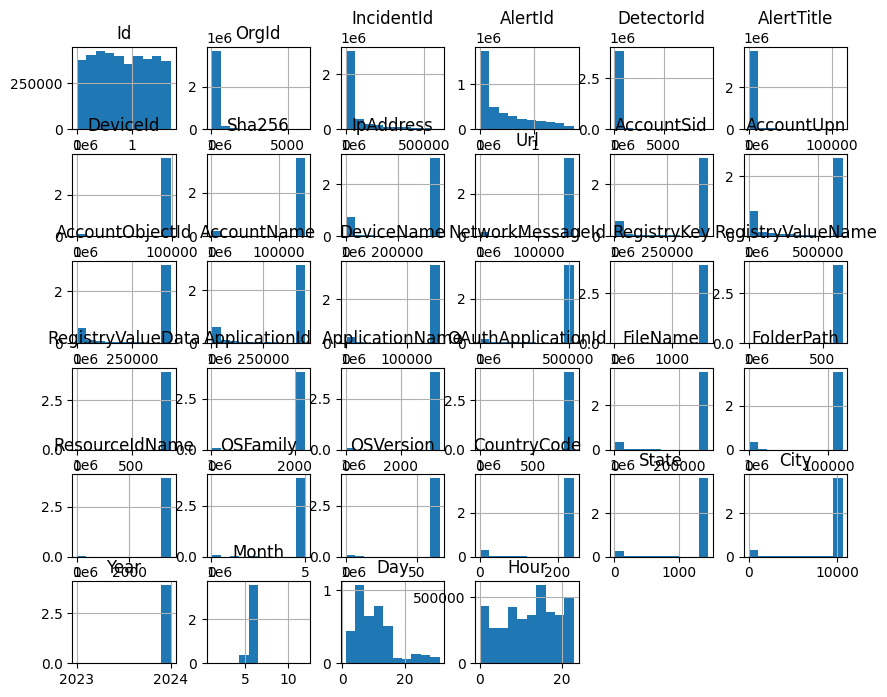

In [83]:
test_data.hist(figsize=(10,8))
plt.show()

In [84]:
# List of numeric columns in DataFrame
numeric_columns = test_data.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])

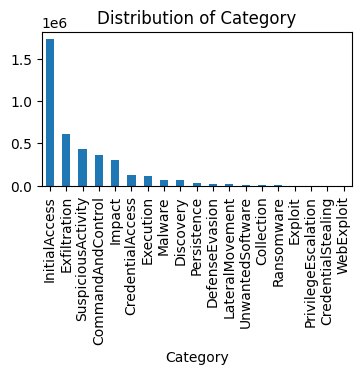

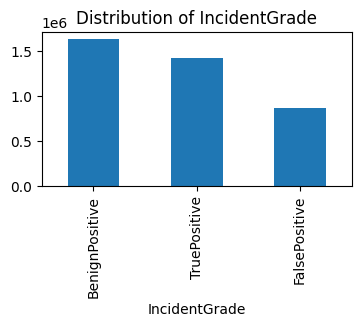

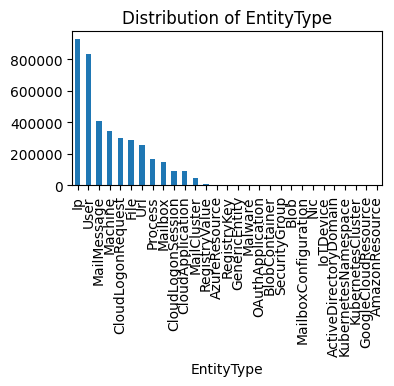

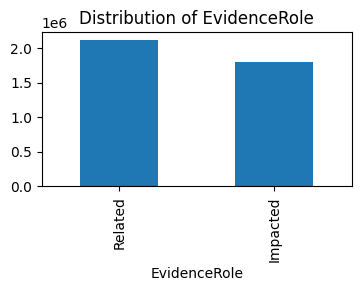

In [85]:
# Bar plot for categorical data
# List of categorical columns in DataFrame
categorical_columns = test_data.select_dtypes(include=['object','category'])

for col in categorical_columns:
    plt.figure(figsize=(4, 2))
    test_data[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.show()

## Visualizing the Data to Identify Outliers

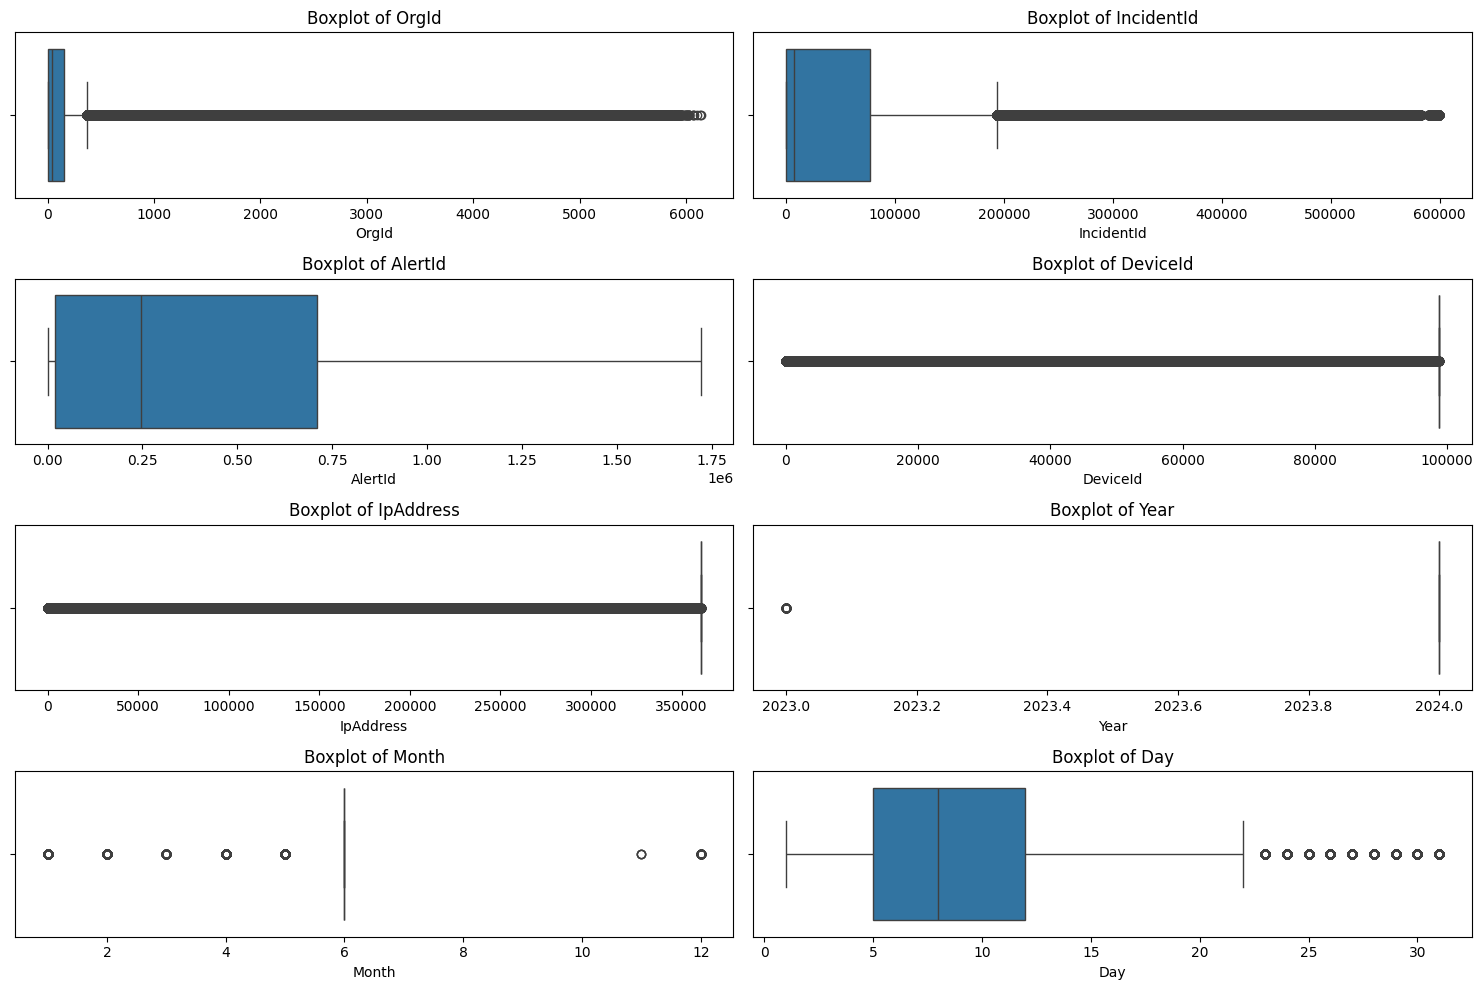

In [86]:
# Ploting box plots for numerical columns
numeric_cols = ['OrgId', 'IncidentId', 'AlertId', 'DeviceId', 'IpAddress', 'Year', 'Month', 'Day']
plt.figure(figsize=(15, 10))
num_plots = len(numeric_cols)
rows = (num_plots + 1) // 2

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=test_data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

## Correlation Analysis

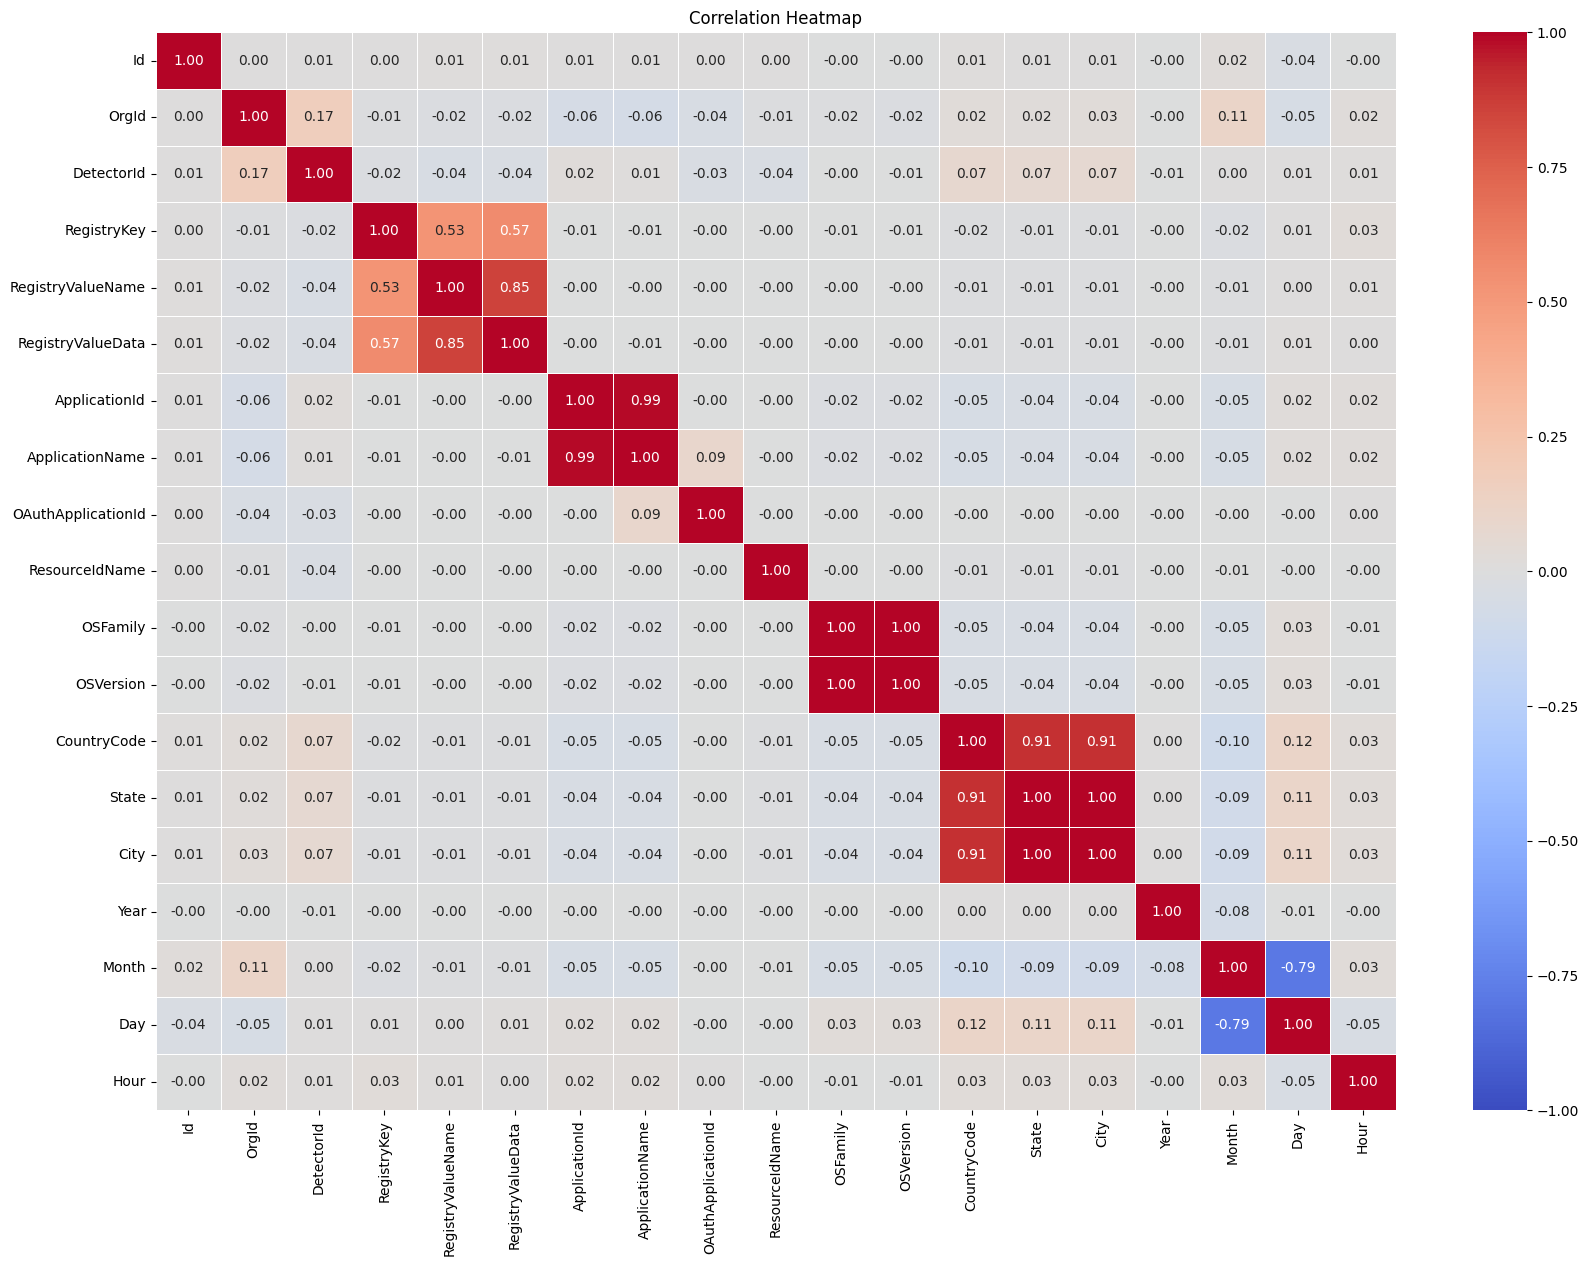

In [87]:
# heatmap visualization
plt.figure(figsize=(20, 14))
sns.heatmap(numeric_columns.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

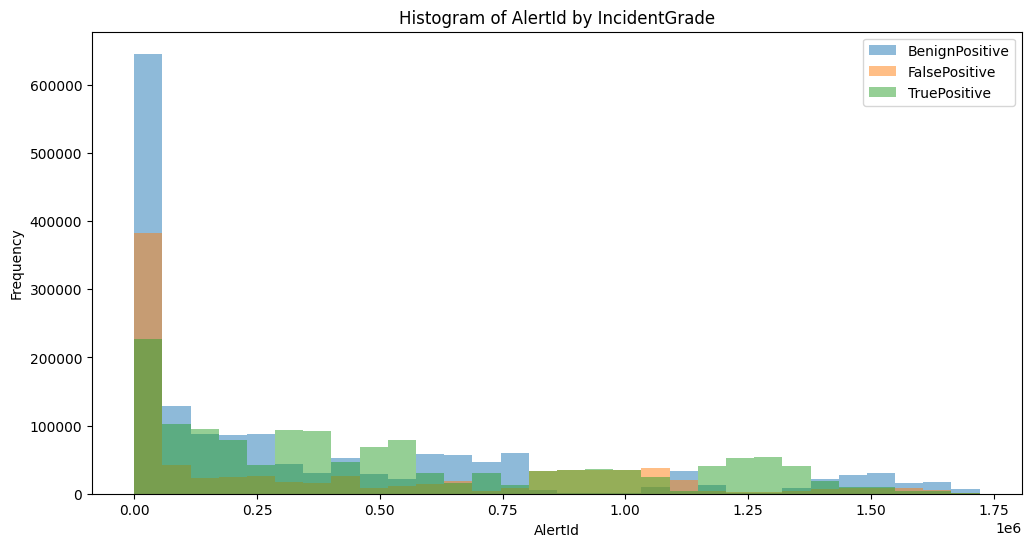

In [88]:
plt.figure(figsize=(12, 6))
for grade in test_data['IncidentGrade'].unique():
    subset = test_data[test_data['IncidentGrade'] == grade]
    plt.hist(subset['AlertId'], bins=30, alpha=0.5, label=grade)

plt.xlabel('AlertId')
plt.ylabel('Frequency')
plt.title('Histogram of AlertId by IncidentGrade')
plt.legend()
plt.show()

## Feature Importance via Random Forest

In [89]:
print(test_data.columns)
len(test_data.columns)

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


38

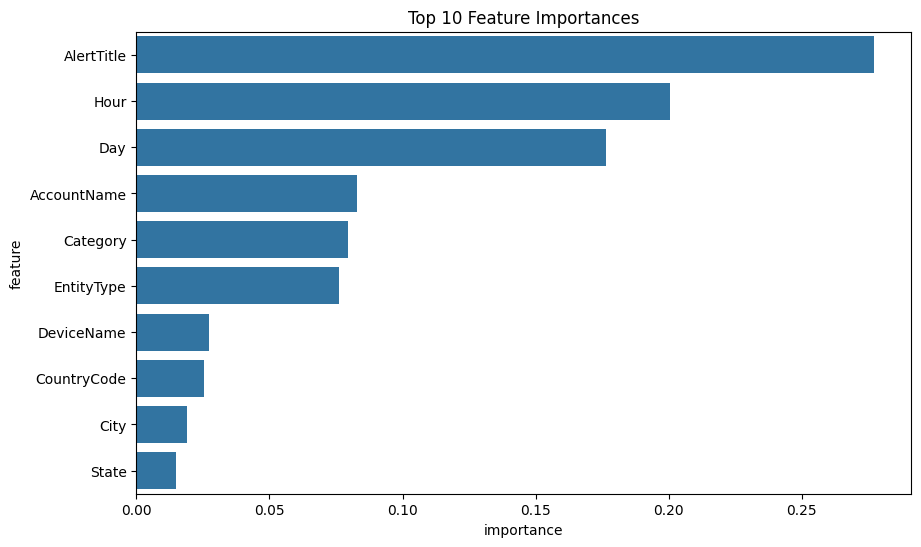

In [90]:
test_sample = test_data.sample(frac=0.001, random_state=42)
X = train_sample.drop(id_columns + ['IncidentGrade'], axis=1, errors='ignore')
y = train_sample['IncidentGrade']

non_numeric_cols = X.select_dtypes(exclude=['number']).columns
le = LabelEncoder()
for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Random Forest model
rf = RandomForestClassifier()
rf.fit(X, y)
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [91]:
# These features have minimal importance or are unlikely to impact your classification outcome
columns_to_drop = [
    'Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DetectorId','Sha256', 'IpAddress', 
    'AccountSid', 'AccountUpn', 'AccountObjectId', 'DeviceId', 'NetworkMessageId',
    'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
    'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSVersion'
]
test_data.drop(columns=columns_to_drop, inplace=True)

In [92]:
test_data.shape

(3922695, 16)

## Handling Outliers

In [93]:
# # Usage
# test_data = handle_outliers(test_data, iqr_multiplier=3.0)

In [94]:
# shape after Handling outliers
test_data.shape

(3922695, 16)

## Scaling/Normalization
## StandardScaler

In [95]:
# # Numerical columns
# # Excludeing ID columns from scaling
# numeric_features = test_data.select_dtypes(include=['number']).drop(columns=id_columns, errors='ignore')

# # Scaling 
# scaler = StandardScaler()

# # Applying StandardScaler to Numerical columns
# test_data[numeric_features.columns] = scaler.fit_transform(numeric_features)

In [96]:
test_data.head()

,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,Url,AccountName,DeviceName,OSFamily,CountryCode,State,City,Year,Month,Day,Hour
0,563,LateralMovement,BenignPositive,User,Impacted,160396,863,153085,5,242,1445,10630,2024,6,4,22
1,2,CommandAndControl,BenignPositive,Machine,Impacted,160396,453297,2833,0,242,1445,10630,2024,6,3,12
2,10807,LateralMovement,BenignPositive,Process,Related,160396,453297,153085,5,242,1445,10630,2024,6,8,3
3,0,InitialAccess,FalsePositive,CloudLogonSession,Related,160396,453297,153085,5,242,1445,10630,2024,6,12,12
4,18,Discovery,BenignPositive,User,Impacted,160396,136104,153085,5,242,1445,10630,2024,6,6,17


In [97]:
test_data.shape

(3922695, 16)

## Encoding Categorical Variables
* Label Encoding for Ordinal Variables
* One-hot encoding for nominal columns

In [98]:
categorical_columns = ['AlertTitle', 'Category', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State', 'City', 'Year',
       'Month', 'Day', 'Hour']

In [99]:
# List of columns to process
columns_to_group = ['AlertTitle', 'Url', 'AccountName', 'DeviceName', 'CountryCode', 'State', 'City']

# Looping through each column and grouping the less frequent values into "Others"
for column in columns_to_group:
    category_counts = test_data[column].value_counts()
    top_categories = category_counts.nlargest(5).index
    test_data[column] = test_data[column].where(test_data[column].isin(top_categories), 'Others')

# Now verifing the changes
test_data

,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,Url,AccountName,DeviceName,OSFamily,CountryCode,State,City,Year,Month,Day,Hour
0,Others,LateralMovement,BenignPositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,4,22
1,2,CommandAndControl,BenignPositive,Machine,Impacted,160396,453297,Others,0,242,1445,10630,2024,6,3,12
2,Others,LateralMovement,BenignPositive,Process,Related,160396,453297,153085,5,242,1445,10630,2024,6,8,3
3,0,InitialAccess,FalsePositive,CloudLogonSession,Related,160396,453297,153085,5,242,1445,10630,2024,6,12,12
4,Others,Discovery,BenignPositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147985,Others,Malware,BenignPositive,Machine,Impacted,160396,453297,4,0,242,1445,10630,2024,6,3,20
4147987,Others,InitialAccess,BenignPositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,4,3
4147988,Others,InitialAccess,BenignPositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,4,19
4147989,Others,CommandAndControl,FalsePositive,Ip,Related,160396,453297,153085,5,242,1445,10630,2024,6,15,0


In [100]:
# Label Encoding for IncidentGrade (Target Variable)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
test_data['IncidentGrade'] = le.fit_transform(test_data['IncidentGrade'])

# One-Hot Encoding for nominal features
test_data = pd.get_dummies(test_data, columns=categorical_columns, drop_first=True)

In [101]:
test_data.shape

(3922695, 148)

## Saving the Cleaned Test Data set as CSV for further processing

In [102]:
print(train_data.shape)
print(test_data.shape)

(8922805, 154)
(3922695, 148)


In [103]:
train_data, test_data = train_data.align(test_data, join='left', axis=1)
test_data.fillna(0, inplace=True)

In [104]:
test_data.shape

(3922695, 154)

In [105]:
test_data = test_data.reset_index(drop=True)

In [106]:
# Saveing the data using Joblib
joblib.dump(test_data, 'encoded_test_data.joblib')

['encoded_test_data.joblib']

In [107]:
# Loading the data using Joblib
test_data = joblib.load('encoded_test_data.joblib')

In [108]:
test_data.head()

,IncidentGrade,AlertTitle_1,AlertTitle_2,AlertTitle_3,AlertTitle_4,AlertTitle_Others,Category_CommandAndControl,Category_CredentialAccess,Category_CredentialStealing,Category_DefenseEvasion,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,0,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,0,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [109]:
# test_data.to_csv("final_test_data.csv",index=False)

In [110]:
print(test_data.memory_usage(deep=True).sum() / (1024 ** 2), "MB")

864.1649980545044 MB
